In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from scipy import stats

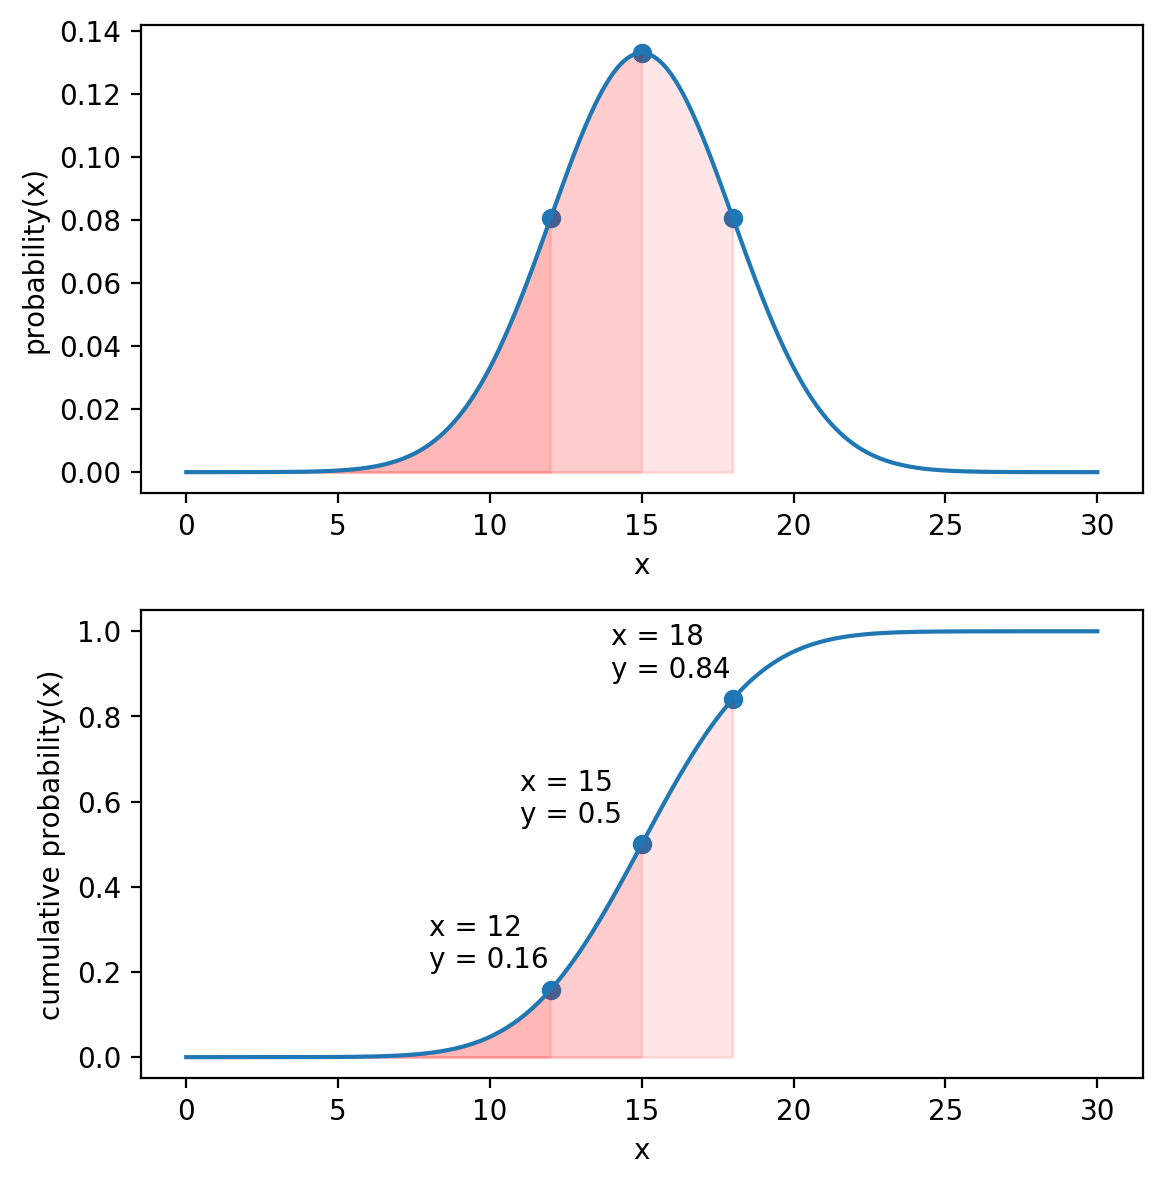

In [43]:
sigma = 3
x = np.linspace(0, 30, 1000)
y = stats.norm.pdf(x, 15, sigma)
cdf = stats.norm.cdf(x, 15, sigma)

x1 = [12, 15, 18]
y1 = stats.norm.pdf(x1, 15, sigma) 
cdf1 = stats.norm.cdf(x1, 15, sigma)  

fig,(ax1,ax2) = plt.subplots(ncols=1,nrows=2, figsize=(6,6))
ax1.plot(x, y)
ax1.scatter(x1, y1)

for val in x1:
    ax1.fill_between(x[x<val], 0, y[x<val], color='r', alpha=0.1)

ax2.plot(x, cdf)
ax2.scatter(x1, cdf1)

for val in x1:
    ax2.fill_between(x[x<val], 0, cdf[x<val], color='r', alpha=0.1)
    
    
for i in range(len(x1)):
    ax2.text(x1[i]-4, cdf1[i]+0.05, 'x = '+str(x1[i])+'\ny = '+str(np.round(cdf1[i],2)))

ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax1.set_ylabel('probability(x)')
ax2.set_ylabel('cumulative probability(x)')
plt.tight_layout()
plt.show()

#### First let's plot the skew normal distribution to understand the parametrization and ranges of reasonable parameter values
The scipy.stats package has a skewed normal model defined by a skewness parameter (a) which informs whether a distribution is skewed positively (a heavier tail toward large values) or negatively (a heavier tail toward small values), a scale parameter (scale) which tells us how broad or how peaked the distribution is, and a location parameter (loc) which is analogous to a mean. Let's see how varying these parameters changes the model.  

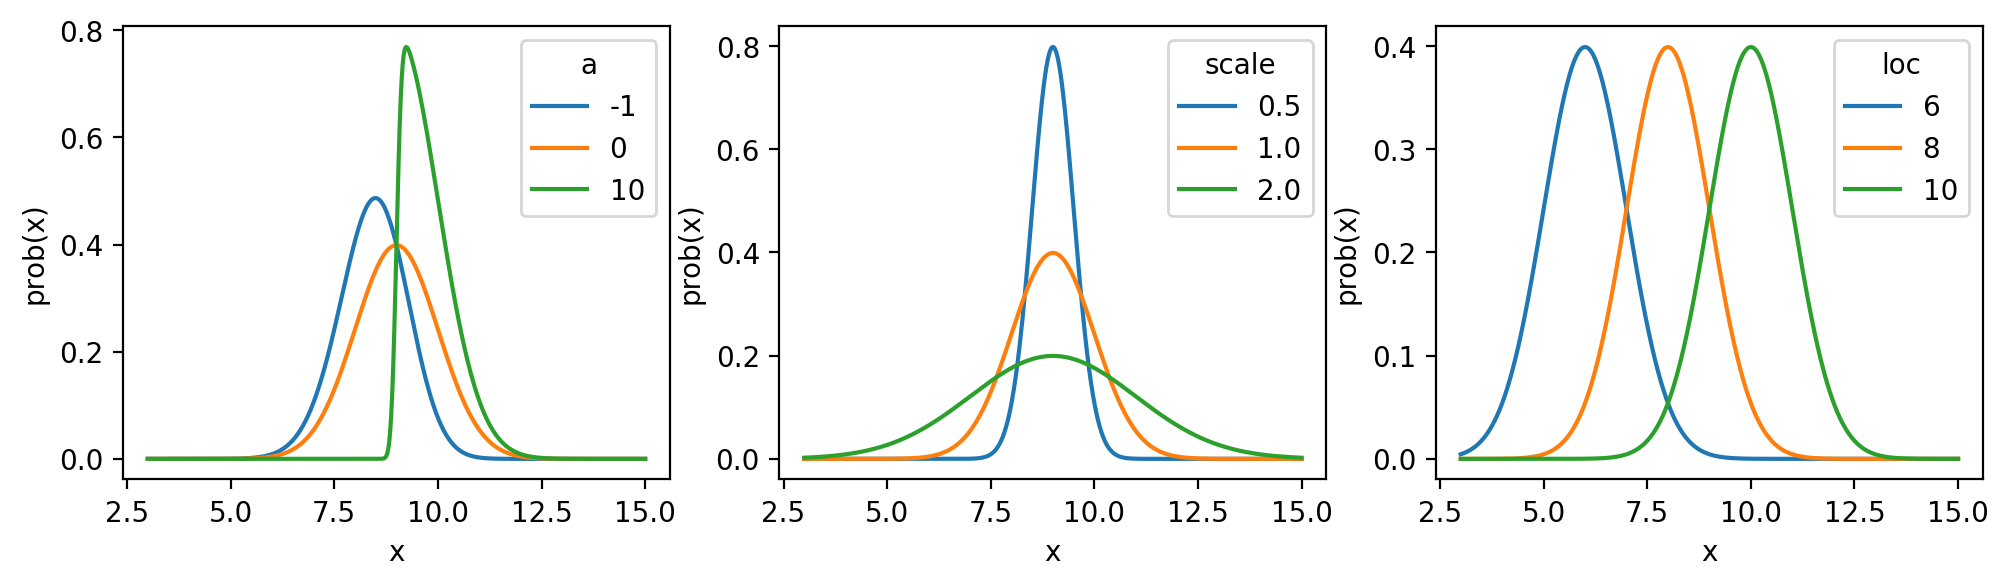

In [36]:
from scipy import stats

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

a = np.array([-1,0,10])
sc = np.array([0.5, 1.0, 2.0])
loc = np.array([6,8,10])

_x = np.linspace(3, 15, 1000)

for _a in a:
    _p = stats.skewnorm.pdf(_x, a=_a, loc=9, scale=1)    
    ax1.plot(_x, _p, label=str(_a))

for _sc in sc:
    _p = stats.skewnorm.pdf(_x, a=0, loc=9, scale=_sc)    
    ax2.plot(_x, _p, label=str(_sc))
    
for _loc in loc:
    _p = stats.skewnorm.pdf(_x, a=0, loc=_loc, scale=1)    
    ax3.plot(_x, _p, label=str(_loc))    
    
    
ax1.legend(title='a')
ax2.legend(title='scale')
ax3.legend(title='loc')

for ax in [ax1,ax2,ax3]:
    ax.set_xlabel('x')
    ax.set_ylabel('prob(x)')

plt.show()

#### Import the CKS age data

In [41]:
import pandas as pd
cks = pd.read_csv('ages.csv')
cks.head()

,KOI,logAiso,E_logAiso,e_logAiso
0,K00001,9.74,0.13,0.15
1,K00002,9.25,0.04,0.05
2,K00006,9.32,0.09,0.24
3,K00007,9.78,0.09,0.08
4,K00008,9.18,0.26,0.52


#### Let's select a star at random and see if we can fit the skew normal quantile function (a.k.a. percent-point function) to the intervals provided in the data table (16th, 50th, and 84th percentiles)

[[Variables]]
    a:     -23.6930617 (init = 0)
    loc:    9.21172091 (init = 8.94)
    scale:  0.43619655 (init = 0.1)


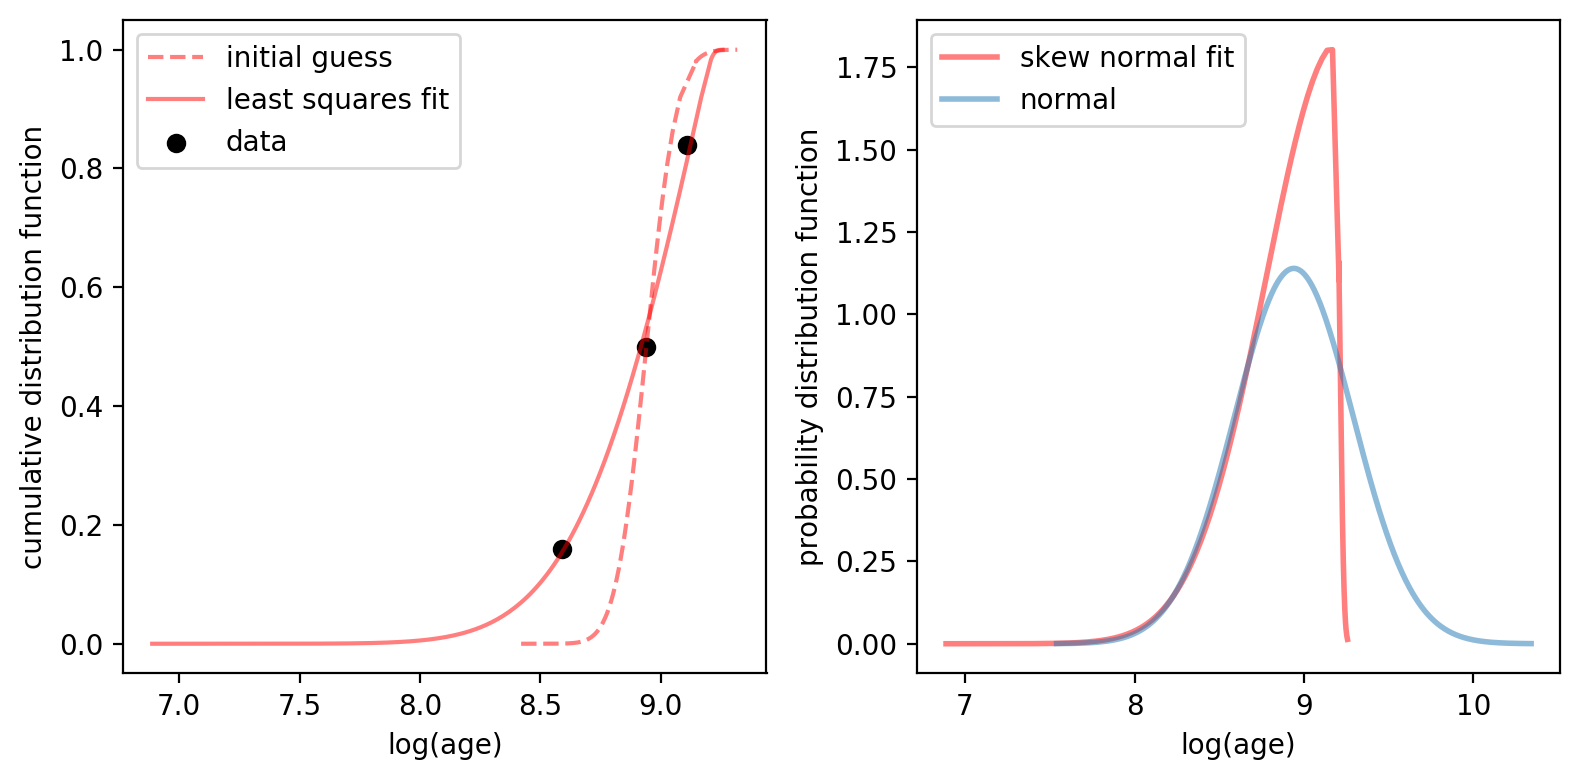

In [116]:
from lmfit import Model, Parameter, report_fit
from lmfit import Minimizer, Parameters, report_fit
#from lmfit.models import SkewedGaussianModel

idx = np.random.choice(len(cks)) # choose a random star from the data set

med = cks['logAiso'][idx] # median (50th percentile)
E   = cks['E_logAiso'][idx] # upper error (gives the 84th percentile when added to median)
e   = cks['e_logAiso'][idx] # lower error (gives the 16th percentile when subtracted from median)

cdf_x = np.array([med-e, med, med+E])
cdf_y = np.array([0.16, 0.50, 0.84])

def skewnorm_ppf(x, a, loc, scale):
    return stats.skewnorm(a, loc, scale).ppf(x)

# The residual function is what we will minimize with a least-squares fit
def residual(pars, data, x=cdf_y):
    model = stats.skewnorm(pars['a'], pars['loc'], pars['scale']).ppf(x)
    return model - data

pfit = Parameters()
pfit.add(name='a', value=0, min=-100, max=100, vary=True)
pfit.add(name='loc', value=med, min=7, max=11, vary=True)
pfit.add(name='scale', value=0.1, min=0, max=2, vary=True)

mini = Minimizer(residual, pfit, fcn_args=(cdf_x, cdf_y))
out = mini.leastsq()
best_fit = cdf_x + out.residual
report_fit(out.params)


fit_y = np.append(np.logspace(-7,-0.008,250),np.linspace(0.98,1,250))
fit_x = skewnorm_ppf(fit_y, 
                     a=out.params['a'].value, 
                     loc=out.params['loc'].value, 
                     scale=out.params['scale'].value)

# Let's plot the initial guess
fit_init = skewnorm_ppf(fit_y, 
                     a=0, 
                     loc=med, 
                     scale=0.1)


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.scatter(cdf_x, cdf_y, color='k', label='data')
ax1.plot(fit_init, fit_y, color='r', ls='--', alpha=0.5, label='initial guess')
ax1.plot(fit_x, fit_y, color='r', alpha=0.5, label='least squares fit')
ax1.set_xlabel('log(age)')
ax1.set_ylabel('cumulative distribution function')
ax1.legend()


fit_pdf = stats.skewnorm.pdf(fit_x, 
                             a=out.params['a'].value, 
                             loc=out.params['loc'].value, 
                             scale=out.params['scale'].value)

ax2.plot(fit_x, fit_pdf, color='r', label='skew normal fit', alpha=0.5, lw=2)

# For comparison let's plot a normal distribution with mean given by the median age and a width given by
# the maximum of the upper and lower errors
norm_x = np.linspace(med-4*np.max([e,E]), med+4*np.max([e,E]), 500)
norm_y = stats.norm(med, np.max([e,E])).pdf(norm_x)
ax2.plot(norm_x, norm_y, label='normal', alpha=0.5, lw=2)

ax2.legend()
ax2.set_xlabel('log(age)')
ax2.set_ylabel('probability distribution function')

plt.tight_layout()

#### Let's try to repeat the exercise above but let's supplement the provided data points with reasonable assumptions for where a realistic age probability distribution would taper off. 
An initial attempt to add arbitrarily low / high cumulative probabilities at log(age) = 7 and log(age) = 11 yielded poor results. The least-squares fit would not always find a solution, or the resulting best-fit solution from the 5 point CDF would look very different from the solution for the 3 point CDF.

Below is an attempt at a more 'realistic' probability distribution. We supplement the 3 point CDF with points that are 5-sigma below / above the median, where we use the lower/upper quantiles respectively as sigma. The cumulative probabilities assigned to these points are the same you would get for 5-sigma above/below the median for a normal (Gaussian) distribution. This assumption is almost certainly wrong, but it appears to work better than the first scheme described above.

[[Variables]]
    a:     -2.55371583 +/- 0.23707500 (9.28%) (init = 0)
    loc:    9.16752186 +/- 0.02580388 (0.28%) (init = 8.94)
    scale:  0.39592529 +/- 0.00938350 (2.37%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, loc)     = -0.758
    C(loc, scale) =  0.735
    C(a, scale)   = -0.680


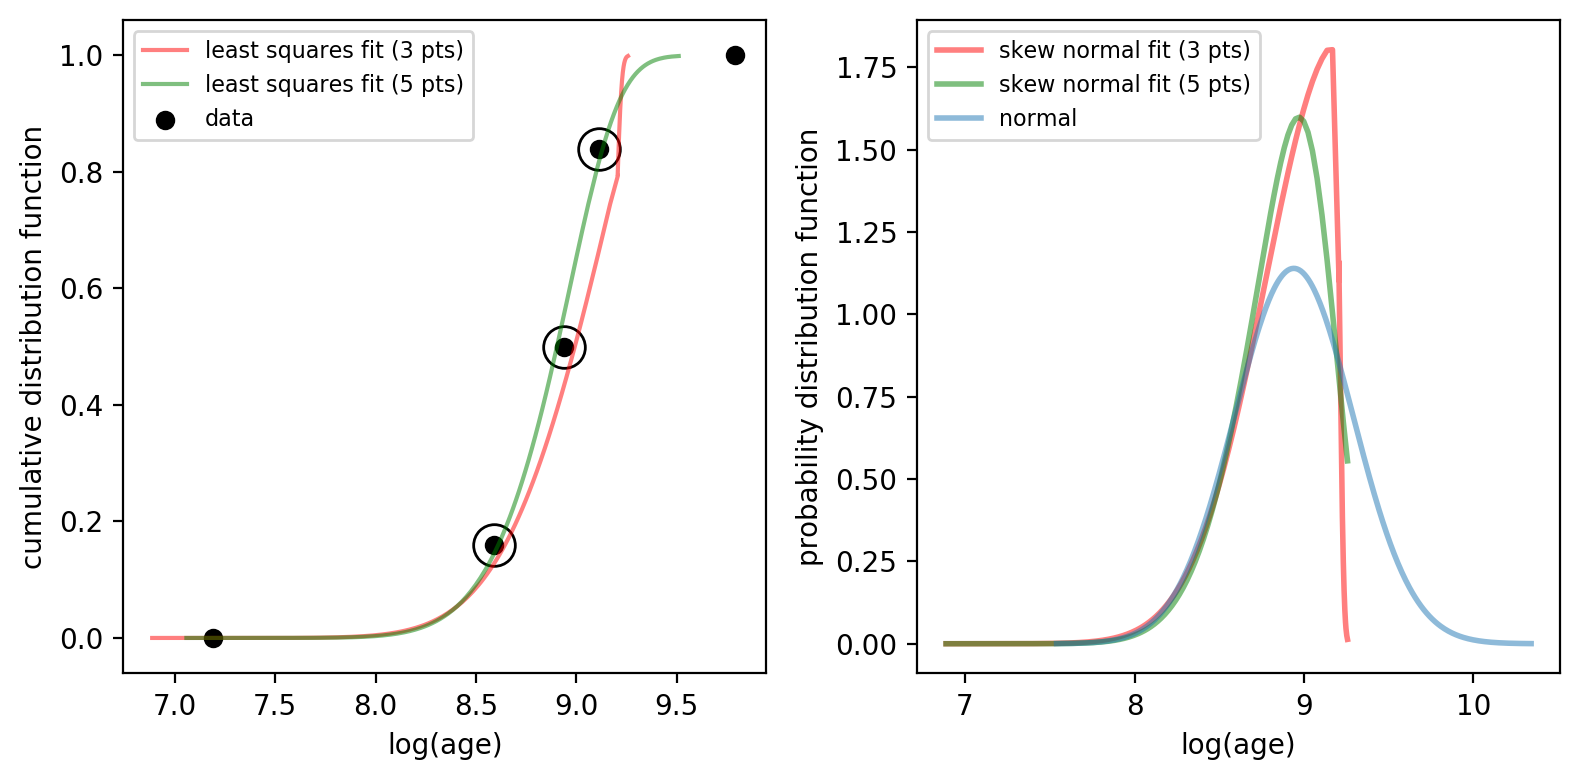

In [117]:
#idx = np.random.choice(len(cks)) # choose a random star from the data set

med = cks['logAiso'][idx] # median (50th percentile)
E   = cks['E_logAiso'][idx] # upper error (gives the 84th percentile when added to median)
e   = cks['e_logAiso'][idx] # lower error (gives the 16th percentile when subtracted from median)

cdf_x = np.array([med-5*e, med-e, med, med+E, med+5*E])
cdf_y = np.array([1-0.999999426697, 0.16, 0.50, 0.84, 0.999999426697])


pfit = Parameters()
pfit.add(name='a', value=0, min=-100, max=100, vary=True)
pfit.add(name='loc', value=med, min=7, max=11, vary=True)
pfit.add(name='scale', value=0.1, min=0, max=2, vary=True)

mini = Minimizer(residual, pfit, fcn_args=(cdf_x, cdf_y))
out = mini.leastsq()
best_fit = cdf_x + out.residual
report_fit(out.params)


fit_y = np.append(np.logspace(-7,-0.1,250),np.logspace(-0.1,0,250))
fit_x2 = skewnorm_ppf(fit_y, 
                     a=out.params['a'].value, 
                     loc=out.params['loc'].value, 
                     scale=out.params['scale'].value)

# Let's plot the initial guess
fit_init = skewnorm_ppf(fit_y, 
                     a=0, 
                     loc=med, 
                     scale=0.1)


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.scatter(cdf_x, cdf_y, color='k', label='data')
ax1.plot(cdf_x[1:4], cdf_y[1:4], 'ko', mfc='None', ms=15)
#ax1.plot(fit_init, fit_y, color='r', ls='--', alpha=0.5, label='initial guess')
ax1.plot(fit_x, fit_y, color='r', alpha=0.5, label='least squares fit (3 pts)')
ax1.plot(fit_x2, fit_y, color='g', alpha=0.5, label='least squares fit (5 pts)')
ax1.set_xlabel('log(age)')
ax1.set_ylabel('cumulative distribution function')
ax1.legend(prop={'size':8})


fit_pdf2 = stats.skewnorm.pdf(fit_x, 
                             a=out.params['a'].value, 
                             loc=out.params['loc'].value, 
                             scale=out.params['scale'].value)

ax2.plot(fit_x, fit_pdf, color='r', label='skew normal fit (3 pts)', alpha=0.5, lw=2)
ax2.plot(fit_x, fit_pdf2, color='g', label='skew normal fit (5 pts)', alpha=0.5, lw=2)

# For comparison let's plot a normal distribution with mean given by the median age and a width given by
# the maximum of the upper and lower errors
norm_x = np.linspace(med-4*np.max([e,E]), med+4*np.max([e,E]), 500)
norm_y = stats.norm(med, np.max([e,E])).pdf(norm_x)
ax2.plot(norm_x, norm_y, label='normal', alpha=0.5, lw=2)
 
ax2.legend(prop={'size':8})
ax2.set_xlabel('log(age)')
ax2.set_ylabel('probability distribution function')

plt.tight_layout()

In [3]:
import numpy as np
print((np.log10(2.0)-np.log10(1.6))/(np.log10(1.2)-np.log10(0.8)))

0.5503397132132085


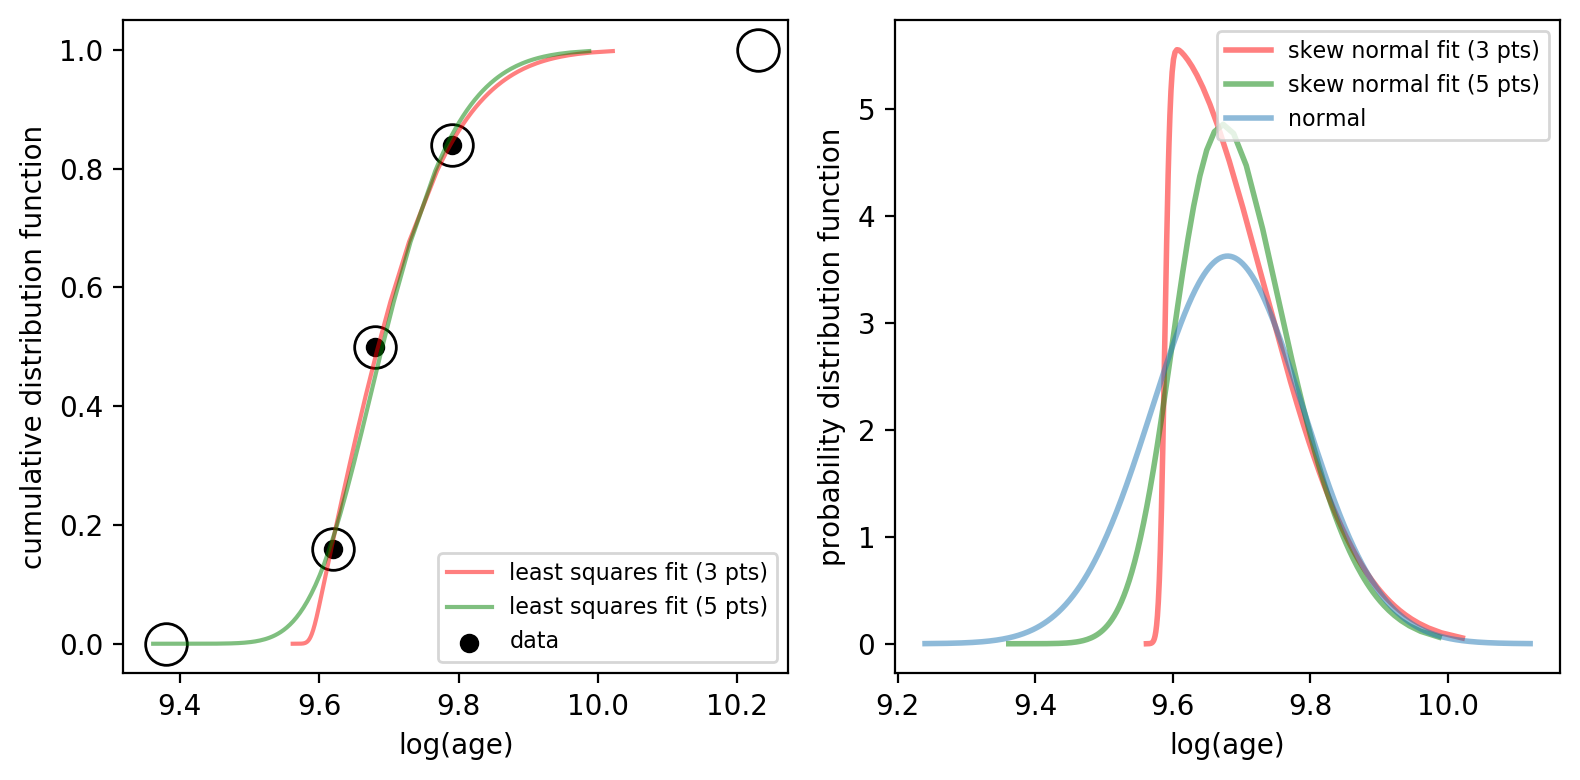

(22.410525660246677,
 9.58861304991822,
 0.14208515356573748,
 2.1430264916427717,
 9.608508178392253,
 0.12443985135898927)

In [126]:
def skewnorm_ppf(x, a, loc, scale):
    return stats.skewnorm(a, loc, scale).ppf(x)

def skewnorm_fit(idx, plot=False):

    med = cks['logAiso'][idx] # median (50th percentile)
    E   = cks['E_logAiso'][idx] # upper error (gives the 84th percentile when added to median)
    e   = cks['e_logAiso'][idx] # lower error (gives the 16th percentile when subtracted from median)

    cdf_x3 = np.array([med-e, med, med+E])
    cdf_y3 = np.array([0.16, 0.50, 0.84])
    
    cdf_x5 = np.array([med-5*e, med-e, med, med+E, med+5*E])
    cdf_y5 = np.array([1-0.999999426697, 0.16, 0.50, 0.84, 0.999999426697])
    
    
    # The residual function is what we will minimize with a least-squares fit
    def residual(pars, data, x):
        model = stats.skewnorm(pars['a'], pars['loc'], pars['scale']).ppf(x)
        return model - data

    pfit = Parameters()
    pfit.add(name='a', value=0, min=-100, max=100, vary=True)
    pfit.add(name='loc', value=med, min=7, max=11, vary=True)
    pfit.add(name='scale', value=0.1, min=0, max=2, vary=True)

    mini3 = Minimizer(residual, pfit, fcn_args=(cdf_x3, cdf_y3))
    out3 = mini3.leastsq()
    
    mini5 = Minimizer(residual, pfit, fcn_args=(cdf_x5, cdf_y5))
    out5 = mini5.leastsq()    
    
    _a3, _loc3, _scale3 = out3.params['a'].value, out3.params['loc'].value, out3.params['scale'].value
    _a5, _loc5, _scale5 = out5.params['a'].value, out5.params['loc'].value, out5.params['scale'].value
    
    if plot==True:
        
        fit_y = np.append(np.logspace(-7,-0.1,100),np.logspace(-0.1,0,100))
        
        fit_x3 = skewnorm_ppf(fit_y, 
                             a=_a3, 
                             loc=_loc3, 
                             scale=_scale3)
        
        fit_x5 = skewnorm_ppf(fit_y, 
                             a=_a5, 
                             loc=_loc5, 
                             scale=_scale5)        
        
        
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

        ax1.scatter(cdf_x3, cdf_y3, color='k', label='data')
        ax1.plot(cdf_x5, cdf_y5, 'ko', mfc='None', ms=15)

        ax1.plot(fit_x3, fit_y, color='r', alpha=0.5, label='least squares fit (3 pts)')
        ax1.plot(fit_x5, fit_y, color='g', alpha=0.5, label='least squares fit (5 pts)')
        ax1.set_xlabel('log(age)')
        ax1.set_ylabel('cumulative distribution function')
        ax1.legend(prop={'size':8})


        fit_pdf3 = stats.skewnorm.pdf(fit_x3, 
                                      a=_a3, 
                                      loc=_loc3, 
                                      scale=_scale3)
        
        fit_pdf5 = stats.skewnorm.pdf(fit_x5, 
                                      a=_a5, 
                                      loc=_loc5, 
                                      scale=_scale5)

        ax2.plot(fit_x3, fit_pdf3, color='r', label='skew normal fit (3 pts)', alpha=0.5, lw=2)
        ax2.plot(fit_x5, fit_pdf5, color='g', label='skew normal fit (5 pts)', alpha=0.5, lw=2)

        # For comparison let's plot a normal distribution with mean given by the median age and a width given by
        # the maximum of the upper and lower errors
        norm_x = np.linspace(med-4*np.max([e,E]), med+4*np.max([e,E]), 500)
        norm_y = stats.norm(med, np.max([e,E])).pdf(norm_x)
        ax2.plot(norm_x, norm_y, label='normal', alpha=0.5, lw=2)

        ax2.legend(prop={'size':8})
        ax2.set_xlabel('log(age)')
        ax2.set_ylabel('probability distribution function')

        plt.tight_layout()        
        plt.show()
        
    return _a3, _loc3, _scale3, _a5, _loc5, _scale5


    
skewnorm_fit(np.random.choice(len(cks)), plot=True)

In [135]:
from tqdm import tqdm

cks['a3'] = np.zeros(len(cks))
cks['loc3'] = np.zeros(len(cks))
cks['scale3'] = np.zeros(len(cks))

cks['a5'] = np.zeros(len(cks))
cks['loc5'] = np.zeros(len(cks))
cks['scale5'] = np.zeros(len(cks))

for i in tqdm(range(len(cks))):
    cks['a3'].iloc[i],cks['loc3'].iloc[i],cks['scale3'].iloc[i],\
    cks['a5'].iloc[i],cks['loc5'].iloc[i],cks['scale5'].iloc[i] = skewnorm_fit(i)


 26%|██▌       | 303/1185 [14:06<47:26,  3.23s/it]


 51%|█████     | 605/1185 [28:55<36:02,  3.73s/it]


 77%|███████▋  | 907/1185 [42:53<11:32,  2.49s/it]


100%|██████████| 1185/1185 [55:47<00:00,  2.83s/it]


In [141]:
cks.to_csv('./cks-skewnormal-shape-parameters.csv', index=False)

In [ ]:
["https://arxiv.org/abs/2012.09239"]